## Imports

In [1]:
# basic ml imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from warnings import filterwarnings

# applying beatuful styling 
import seaborn as sns
sns.set()
# to ignore warnings when using Grid Search
filterwarnings(action='ignore',
               message=".*Setting penalty='none' will ignore the C and l1_ratio parameters.*")
# debugging tool
from IPython.core.debugger import set_trace
# my tools module
import tools


In [2]:
# debugging fragment
from importlib import reload
reload(tools)

<module 'tools' from '/home/vsevolod/Documents/python_stuff/kaggel-titanic-competition/tools.py'>

## Data cleaning

In [3]:
df_all = pd.read_csv('data/train.csv')
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# print count of na values.
column_wise_nans = df_all.isna().sum(0)
percent_of_nans = column_wise_nans / df_all.shape[0] * 100
print(f'Percent of nans in columns: \n\n{percent_of_nans}')

Percent of nans in columns: 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [5]:
# dropping useless labels
df_cleaned = df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

# working with na
df_cleaned.dropna(inplace=True)
# using one hot encoding for categorical data
df_cleaned = pd.get_dummies(df_cleaned, columns=['Sex', 'Embarked'])

df_cleaned.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


Split data on training/test

In [6]:
df_X = df_cleaned.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_cleaned['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


## Fooling around with data

In [7]:
df_visualization = df_all.copy()
df_visualization.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1, inplace=True)
df_visualization['Sex'] = df_visualization['Sex'].replace(['female', 'male'], [0, 1])
df_visualization.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [10]:
df_visualization.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

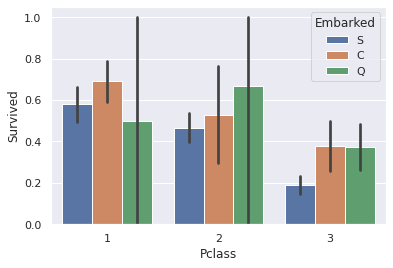

In [11]:
sns.barplot(x='Pclass', y='Survived', hue='Embarked', data=df_visualization)

In [12]:
drop_elements = 10
max_values_indexes = np.argpartition(-df_visualization['Fare'], drop_elements)[:drop_elements]
df_visualization.drop(max_values_indexes, axis=0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S
887,1,1,0,19.0,0,0,30.0000,S
888,0,3,0,NaN,1,2,23.4500,S
889,1,1,1,26.0,0,0,30.0000,C


<AxesSubplot:xlabel='Sex', ylabel='count'>

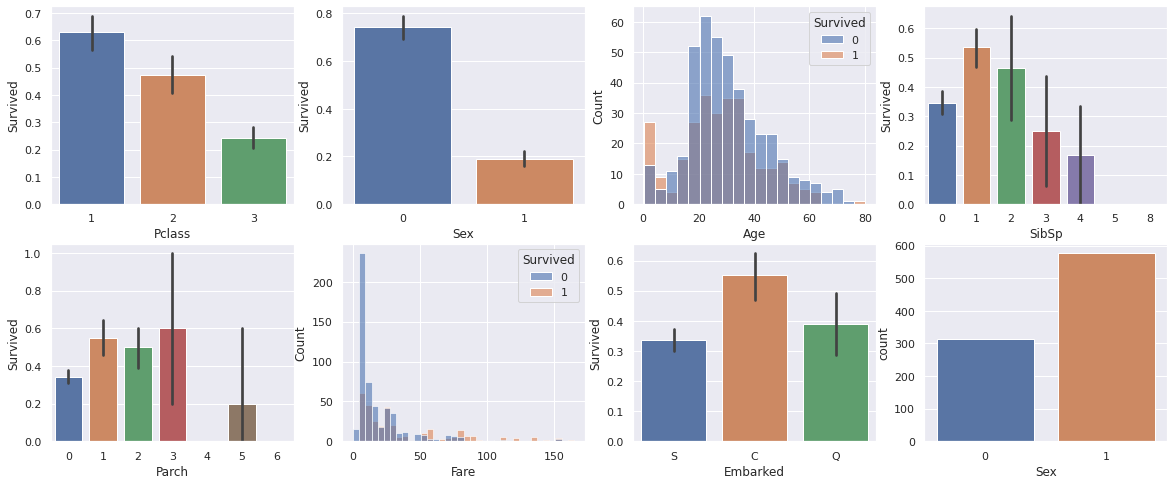

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.barplot(data=df_visualization, x='Pclass', y='Survived', ax=axes[0,0])
sns.barplot(data=df_visualization, x='Sex', y='Survived', ax=axes[0, 1])
sns.histplot(data=df_visualization, x='Age', ax=axes[0, 2], hue='Survived', multiple='layer', alpha=0.6)
sns.barplot(data=df_visualization, x='SibSp', y='Survived', ax=axes[0, 3])
sns.barplot(data=df_visualization, x='Parch', y='Survived', ax=axes[1, 0])

fare_drop_cnt = 20
drop_indexes = np.argpartition(-df_visualization['Fare'], fare_drop_cnt)[:fare_drop_cnt]
sns.histplot(data=df_visualization.drop(drop_indexes, axis=0), x='Fare', ax=axes[1, 1], hue='Survived', multiple='layer', alpha=0.6)

sns.barplot(data=df_visualization, x='Embarked', y='Survived', ax=axes[1, 2])
sns.countplot(data=df_visualization, x='Sex',  ax=axes[1, 3])


SibSp и  Parch явно оверфитнуты

In [14]:
playing_with_penalty(C=1)

NameError: name 'playing_with_penalty' is not defined

In [ ]:
tools.get_coefs_of_regression(model_without_sex['estimator'], df_X.drop(labels=['Sex_female', 'Sex_male', ], axis=1))

plots below says:
1. nothing interesting to woman
2. mens with 1 SibSp have increased survivability, but with 0 have vary little survavability
3. we have a lot of womans compared to mans when SibSp=1

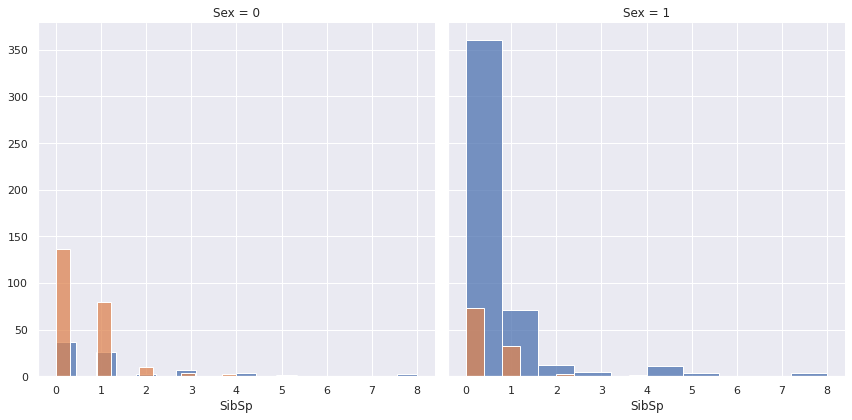

In [15]:
g = sns.FacetGrid(df_visualization, col='Sex', hue='Survived', height=6)
g.map(sns.histplot, 'SibSp')
plt.show()

plots below says:
1. nothing interesting to woman(again)
2. mens with 1 parch have increased survivability, but with 0 have very little survavability
3. we have a lot of mans compared to womans when Parch=0

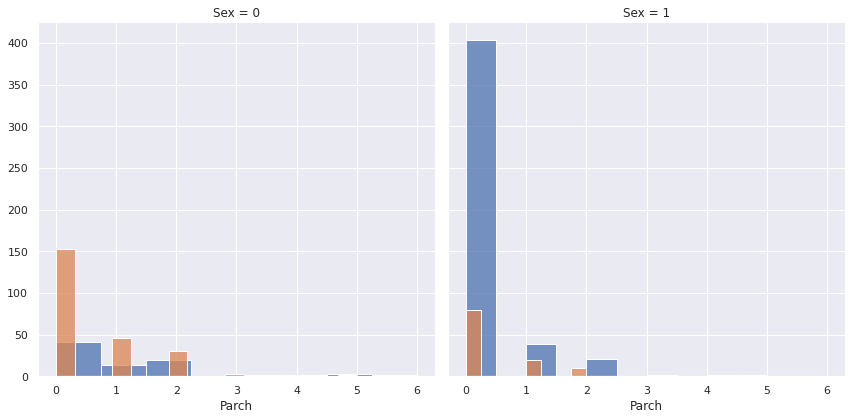

In [16]:
g = sns.FacetGrid(df_visualization, col='Sex', hue='Survived', height=6)
g.map(sns.histplot, 'Parch')

## Training stupid logistic regression

Split data on training/test

In [17]:
df_X = df_cleaned.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_cleaned['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


score: 0.8421052631578947
best params: {'estimator__C': 10, 'estimator__fit_intercept': False}


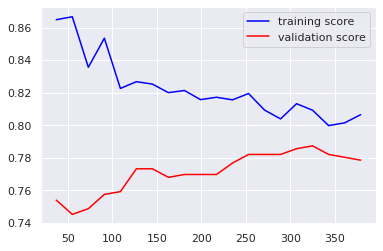

In [18]:
model_all_features = tools.train_estimator_via_grid(X_train, y_train)[0]


In [19]:
tools.get_coefs_of_regression(model_all_features['estimator'], df_X)

Pclass       -2.084645
Age          -2.574755
SibSp        -0.676626
Parch        -1.185762
Fare          1.309721
Sex_female    2.543142
Sex_male      0.054230
Embarked_C    1.132849
Embarked_Q    0.546246
Embarked_S    0.918277
dtype: float64

## Trying add/delete new features to increase performance of logistic regression

In [20]:
def display_estimator_result(X_train, y_train, C=0.01):
    model = Pipeline([('data_transformer', MinMaxScaler()),
                      ('estimator', LogisticRegression(C=C, fit_intercept=False))])
    cv_result = cross_validate(model, X_train, y_train, cv=5)
    tools.plot_learning_curves(model, X_train, y_train)
    print(cv_result['test_score'])
    return model.fit(X_train, y_train)

## Let's combine two estimators

In this section I want to implement estimator that will combine results of prediction based only on "Sex" parameter and on prediction based on other parameters

score: 0.7622377622377622
best params: {'estimator__C': 1, 'estimator__fit_intercept': False}


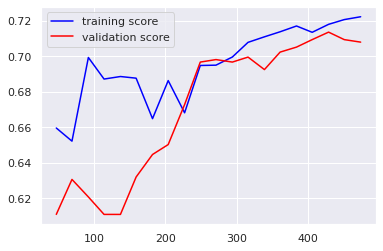

In [21]:
model_without_sex, X_test_without_sex, y_test_without_sex = tools.train_estimator_via_grid(tools.drop_df_columns(df_cleaned, ['Sex_female', 'Sex_male', 'Survived']), df_cleaned['Survived'])

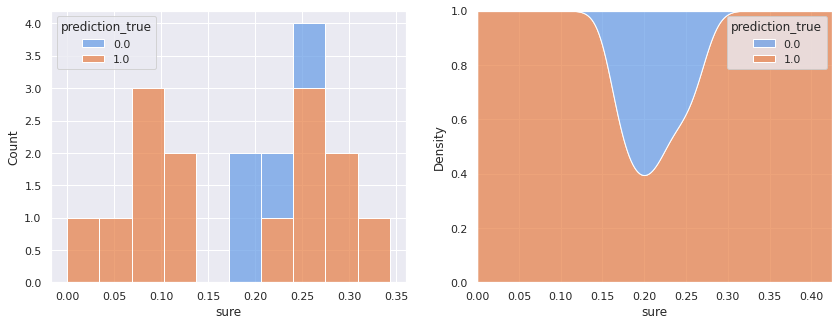

In [22]:
tools.plot_model_accuracy_against_probability(model_without_sex, X_test_without_sex, y_test_without_sex)

Trying to train model  without sex and  age

In [23]:
df_nans = df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
df_nans.dropna(inplace=True, subset=['Embarked'])
df_nans = pd.get_dummies(df_nans, columns=['Sex', 'Embarked'])
df_nans.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


score: 0.651685393258427
best params: {'estimator__C': 10, 'estimator__fit_intercept': True}


Pclass       -1.751222
SibSp        -0.854633
Parch         1.881883
Fare          1.100774
Embarked_C    0.077250
Embarked_Q    0.396073
Embarked_S   -0.471655
dtype: float64

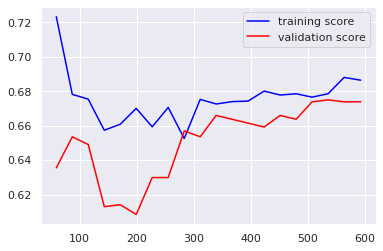

In [24]:
df = df_nans.drop(labels=['Sex_female', 'Sex_male', 'Age', 'Survived'], axis=1)
model_without_age,  _, _ = tools.train_estimator_via_grid(df, df_nans['Survived'])
tools.get_coefs_of_regression(model_without_age['estimator'], df)

In [25]:
df_one_hot = df_cleaned.copy()
df_one_hot['Age'] = pd.cut(df_one_hot['Age'], bins=20)
df_one_hot = pd.get_dummies(df_one_hot, columns=['SibSp', 'Parch', 'Age'])

Он не мог тренироваться гридом, потому что у него заканчивались итерации

Эта модель ведет себя крайне странно, потому что иногда происходят ситуации,когда с увеличением уверенности алгоритма в предсказании его результат только ухудшается, то есть скорее всего такая модель занимается какими-то странными везами, но не предсказанием результата

0.7951785714285714


Pclass                 -1.316779
Fare                    0.302214
Sex_female              1.257195
Sex_male               -1.257190
Embarked_C              0.613309
Embarked_Q             -0.804268
Embarked_S              0.190964
SibSp_0                 0.585870
SibSp_1                 0.220532
SibSp_2                -0.384378
SibSp_3                -0.195397
SibSp_4                -0.044958
SibSp_5                -0.181665
Parch_0                -0.058906
Parch_1                 0.390285
Parch_2                 0.088498
Parch_3                 0.425103
Parch_4                -0.354028
Parch_5                -0.120148
Parch_6                -0.370800
Age_(0.34, 4.399]       1.465958
Age_(4.399, 8.378]      0.727634
Age_(8.378, 12.357]    -1.168273
Age_(12.357, 16.336]    0.758481
Age_(16.336, 20.315]   -0.094695
Age_(20.315, 24.294]   -0.255192
Age_(24.294, 28.273]    0.112453
Age_(28.273, 32.252]    0.393044
Age_(32.252, 36.231]    0.101641
Age_(36.231, 40.21]    -0.159152
Age_(40.21

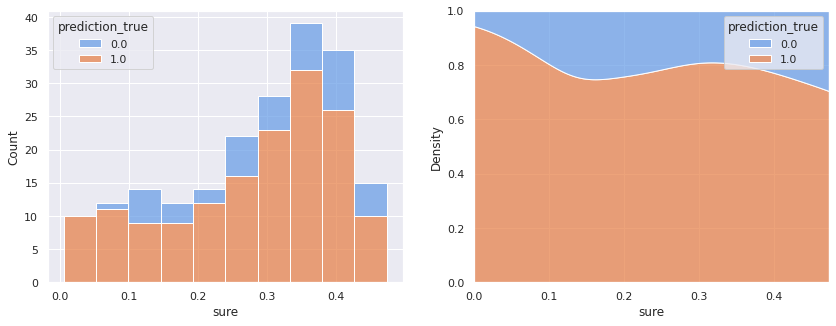

In [26]:
df = df_one_hot.drop(labels=['Survived'], axis=1)
y = df_one_hot['Survived']
model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(C=1, max_iter=1e3))])

validate_score = cross_validate(X=df,
                                y=df_one_hot['Survived'],
                                estimator=model, cv=100)
print(validate_score['test_score'].mean())

X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.4)
model.fit(X_train, y_train)
tools.plot_model_accuracy_against_probability(model, X_test, y_test)
tools.get_coefs_of_regression(model['estimator'], df)

попытаюсь избавиться от возраста

Опять же в данном случае избавление от возраста не позволяет нам избежать ситуации, в которой вероятность предсказания модели могла бы нам что-то говорить

val score: 0.7930298990668445


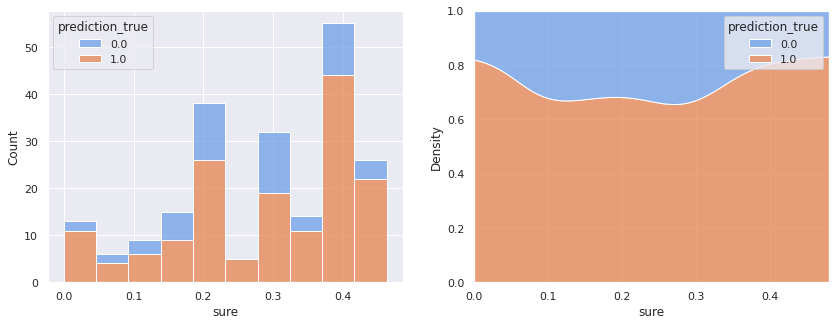

In [27]:
df = df_nans.drop(labels=['Age', 'Survived'], axis=1)
df = pd.get_dummies(df, columns=['SibSp', 'Parch'])
y = df_nans['Survived']
model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(C=1, max_iter=1e3))])

validate_score = cross_validate(X=df,
                                y=y,
                                estimator=model, cv=5)
print('val score:', validate_score['test_score'].mean())

X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.5)
model.fit(X_train, y_train)
tools.plot_model_accuracy_against_probability(model, X_test, y_test)
plt.show()

Model only based on sex parameter(worst thing in th entire universe)

In [28]:
model_with_sex, X_train_with_sex, y_train_with_sex = tools.train_estimator_via_grid(df_X[['Sex_male', 'Sex_female']], y)

ValueError: Found input variables with inconsistent numbers of samples: [712, 889]

## Playing with penalty

In [36]:

def playing_with_penalty(C=1, penalty='l2'):
    X = df_cleaned.drop(labels=['Survived'], axis=1)
    y = df_cleaned['Survived']
    model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(penalty=penalty, C=C))])
    tools.plot_learning_curves(model, X, y)
    model.fit(X, y)
    return tools.get_coefs_of_regression(model['estimator'], df_X)

Pclass       -2.398508
Age          -3.449790
SibSp        -1.816012
Parch        -0.361639
Fare          0.733461
Sex_female    2.053544
Sex_male     -0.584941
Embarked_C    0.897811
Embarked_Q    0.074209
Embarked_S    0.496582
dtype: float64

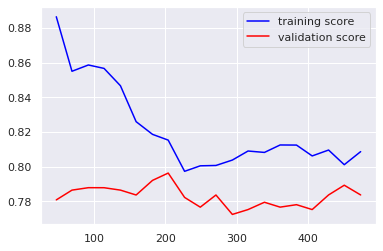

In [37]:
# small penalty
playing_with_penalty(C=1e6)

Pclass       -2.393811
Age          -3.430685
SibSp        -1.803842
Parch        -0.360502
Fare          0.725396
Sex_female    1.320790
Sex_male     -1.315619
Embarked_C    0.410035
Embarked_Q   -0.412723
Embarked_S    0.007858
dtype: float64

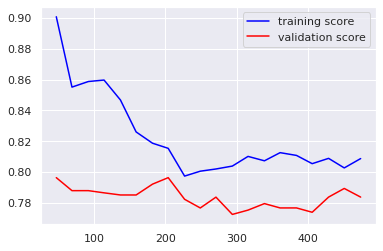

In [40]:
playing_with_penalty(C=1e2)

Pclass       -2.063324
Age          -2.259569
SibSp        -1.117715
Parch        -0.263937
Fare          0.423856
Sex_female    1.250759
Sex_male     -1.251334
Embarked_C    0.401858
Embarked_Q   -0.352032
Embarked_S   -0.050401
dtype: float64

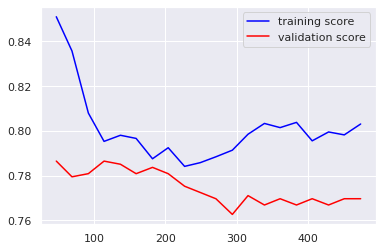

In [41]:
# bigger penalty
playing_with_penalty(C=1)

Pclass       -1.525622
Age          -0.947809
SibSp        -0.451387
Parch        -0.102234
Fare          0.255880
Sex_female    1.129621
Sex_male     -1.129637
Embarked_C    0.364831
Embarked_Q   -0.242163
Embarked_S   -0.122685
dtype: float64

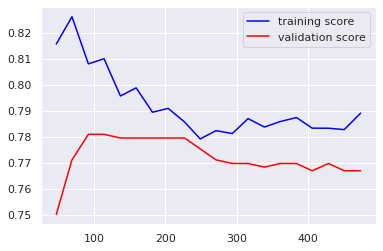

In [42]:
playing_with_penalty(C=0.2)

Pclass       -0.352486
Age          -0.052472
SibSp        -0.021975
Parch         0.019217
Fare          0.061180
Sex_female    0.489238
Sex_male     -0.489239
Embarked_C    0.143369
Embarked_Q   -0.032840
Embarked_S   -0.110530
dtype: float64

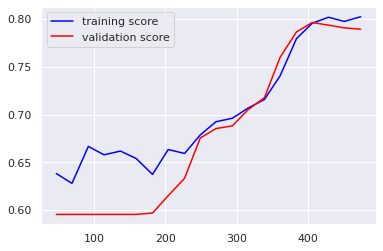

In [43]:
# really strong penalty
playing_with_penalty(C=0.01)

### Covariance matrix

In [45]:
covariance = df_cleaned.cov()

covariance.style.background_gradient(cmap='coolwarm').format(precision=2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,0.24,-0.15,-0.59,-0.01,0.04,6.92,0.13,-0.13,0.04,-0.00,-0.03
Pclass,-0.15,0.70,-4.44,0.05,0.02,-24.49,-0.06,0.06,-0.09,0.02,0.07
Age,-0.59,-4.44,210.05,-4.15,-2.33,71.46,-0.69,0.69,0.21,-0.06,-0.15
SibSp,-0.01,0.05,-4.15,0.87,0.30,6.89,0.05,-0.05,-0.02,0.01,0.01
Parch,0.04,0.02,-2.33,0.30,0.73,9.34,0.10,-0.10,-0.00,-0.00,0.00
Fare,6.92,-24.49,71.46,6.89,9.34,2802.50,4.65,-4.65,6.17,-0.64,-5.53
Sex_female,0.13,-0.06,-0.69,0.05,0.10,4.65,0.23,-0.23,0.02,0.00,-0.02
Sex_male,-0.13,0.06,0.69,-0.05,-0.10,-4.65,-0.23,0.23,-0.02,-0.00,0.02
Embarked_C,0.04,-0.09,0.21,-0.02,-0.00,6.17,0.02,-0.02,0.15,-0.01,-0.14
Embarked_Q,-0.00,0.02,-0.06,0.01,-0.00,-0.64,0.00,-0.00,-0.01,0.04,-0.03


## Let's try svm

### default dataset without nans

In [46]:
from sklearn.svm import SVC

In [47]:
df_X = df_cleaned.drop(labels=['Survived'], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(df_X,
                                                    df_cleaned['Survived'],
                                                    train_size=0.8)

In [52]:
def funning_with_svm(**kwargs):
    model = Pipeline([('data_transformer', MinMaxScaler()),
                      ('estimator', SVC(**kwargs))])
    tools.plot_learning_curves(model, df_X, df_cleaned['Survived'])
    print (cross_validate(model, X_train, y_train, cv=5)['test_score'].mean())

Yeah! this model can be complexity enough to overfit data. Maybe, I can find parameters to get just right

0.7856388759509393


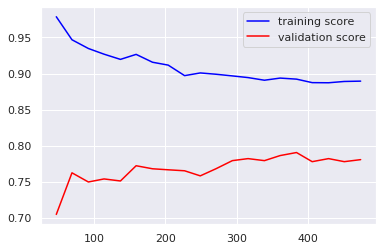

In [65]:
funning_with_svm(C=10, gamma=10 ,kernel='rbf')

0.7785747554727527


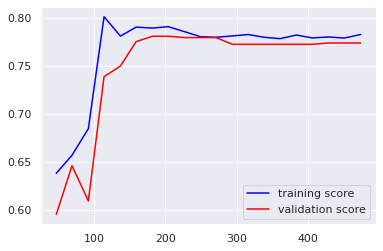

In [55]:
funning_with_svm(C=0.1, kernel='rbf')

0.7715572116131036


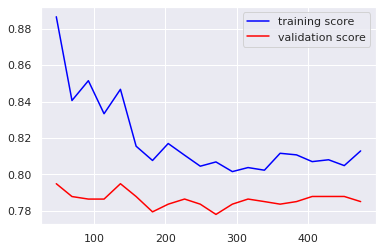

In [66]:
funning_with_svm(C=1, kernel='rbf', gamma=1)

In [ ]:
def grid_search_learning_curves(model, grid_param1, grid_param2, **other_param):
    'let rows - parameter 1, column - parameter 2'
    pass


## Fooling around with deep learning

In [ ]:
# my stupid and random try to deep learning without knowing anything
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_shape=(10, )))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])


titanic_recognition_model = model.fit(X_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

plt.plot(titanic_recognition_model.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(titanic_recognition_model.history['accuracy'], '--s', label='training accuracy')
plt.legend();